In [1]:
## Uncomment these lines if running as a google colab notebook: 
##! git clone https://github.com/kundajelab/adar_editing
##import os
##os.chdir("adar_editing/xgboost_with_shap/")
##!pip install -e https://github.com/slundberg/shap
##!pip install --upgrade xgboost
##!pip install cufflinks

def enable_plotly_in_cell():
  import IPython
  from plotly.offline import init_notebook_mode
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
  '''))


In [2]:
%load_ext autoreload
%autoreload 2    
#helper utilities for model training and interpretation 
from helpers import * 

#set a random seed so code is reproducible 
random.seed(1234)

# load JS visualization code to notebook
shap.initjs()
import warnings
warnings.filterwarnings('ignore')

#visualization utilities 
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import plotly.plotly as py
import numpy as np
from plotly.offline import iplot
from plotly.graph_objs import Heatmap


/users/annashch/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d



## AJUBA xgboost with TreeShap <a name='outline'>
<ol>
    <li><a href=#1>Computational Dataset</a></li>
    <li><a href=#2>Computational Dataset Feature Subsets</a></li>
 </ol>


## AJUBA Computational features<a name='1'>
<a href=#outline>Home</a>

In [3]:
## Read in the data 
import pandas as pd 
data=pd.read_csv("../xin_feature_matrices/ajuba_bc_computational.features.csv",header=0,sep=',',index_col=0)

In [4]:
#remove any null editing level values 
data=data[~data["editing_value"].isnull().values]

In [5]:
## prepare data for training with xgboost 
data=format_for_xgboost(data)

(482, 179)


In [6]:
train_split,eval_split,test_split=split_train_test_eval_by_mut_pos(data)

{120.0: 22, 121.0: 21, 122.0: 22, 123.0: 22, 124.0: 22, 125.0: 23, 126.0: 23, 127.0: 24, 128.0: 23, 129.0: 33, 131.0: 33, 132.0: 24, 133.0: 24, 134.0: 23, 135.0: 23, 136.0: 22, 137.0: 22, 138.0: 22, 139.0: 22, 140.0: 22, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 10}


In [7]:
#Remove any non-varying features 
train_novar=get_singleval_features(train_split)
eval_novar=get_singleval_features(eval_split)
test_novar=get_singleval_features(test_split)
uniform_features_to_drop=list(set(train_novar+eval_novar+test_novar))

In [8]:
#Remove any null features 
train_null=get_all_null_features(train_split)
eval_null=get_all_null_features(eval_split)
test_null=get_all_null_features(test_split)
null_features_to_drop=list(set(train_null+eval_null+test_null))

In [9]:
to_drop=list(set(uniform_features_to_drop+null_features_to_drop))
print("\n".join(to_drop))

mut_ref_struct:I
d2_length_hairpin
site_3prm_cp_bulge:A:U
mut_next_struct:B
site_prev_nt:U
d2_exist
u1_length_internal_ecs
d1_length_internal_es
u2_5prm_cp_hairpin
d2_3prm_cp_internal:A:U
u1_length_internal_es
u2_length_internal_ecs
u1_5prm_cp_hairpin
site_next_struct:S
d1_struct:S
u2_length_hairpin
u3_3prm_cp_bulge:U:G
u3_length_internal_ecs
u3_3prm_cp_internal
u1_3prm_cp_bulge:C:G
d3_length_bulge
u3_5prm_cp_internal
u2_5prm_cp_internal
u3_length_hairpin
d1_3prm_cp_bulge:G:U
u3_5prm_cp_bulge:C:G
site_length_hairpin
u2_3prm_cp_internal
u2_exist
d2_3prm_cp_internal:U:A
d1_length_bulge
u3_5prm_cp_bulge:G:C
d1_struct:B
u3_5prm_cp_hairpin
u3_length_internal_es
u1_5prm_cp_internal
d1_length_internal_ecs
u1_exist
u3_exist
d3_length_hairpin
d1_3prm_cp_internal:G:U
d1_5prm_cp_internal:G:C
mut_ref_nt:U
u3_struct:B
mut_ref_nt:C
site_3prm_cp_internal:C:G
u1_3prm_cp_bulge:U:A
d2_3prm_cp_internal:C:G
u3_length_bulge
mut_ref_nt:A
d1_5prm_cp_hairpin
d3_3prm_cp_bulge
site_next_struct:B
u3_struct:S
sit

In [10]:
train_split=train_split.drop(to_drop,axis=1)
eval_split=eval_split.drop(to_drop,axis=1)
test_split=test_split.drop(to_drop,axis=1)

In [11]:
train_y=train_split['editing_value']
train_X=train_split.drop(['editing_value'],axis=1)

eval_y=eval_split['editing_value']
eval_X=eval_split.drop(['editing_value'],axis=1)

test_y=test_split['editing_value']
test_X=test_split.drop(['editing_value'],axis=1)

In [12]:
print(train_X.shape)
print(train_y.shape)
print(eval_X.shape)
print(eval_y.shape)
print(test_X.shape)
print(test_y.shape)


(326, 92)
(326,)
(77, 92)
(77,)
(99, 92)
(99,)


In [13]:
## format matrixes for xgboost 
dtrain=xgboost.DMatrix(train_X,train_y)
deval=xgboost.DMatrix(eval_X,eval_y)
dtest=xgboost.DMatrix(test_X,test_y)

In [14]:
## set model training parameters 
param=dict() 
param['nthread'] = 20
#rmse -- root mean square error 
# mae -- mean absolute error 
# map -- mean average precision 
# auc -- area under ROC curve 
# aucpr -- area under precision recall curve 
param['eval_metric'] = ['auc','mae','map','aucpr','rmse']

In [15]:
evallist = [(deval, 'eval'), (dtrain, 'train')]


In [16]:
num_round = 1000
bst = xgboost.train(param, dtrain, num_round, evallist,early_stopping_rounds=10)

[15:18:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[0]	eval-auc:0.73592	eval-mae:0.313874	eval-map:1	eval-aucpr:0.177686	eval-rmse:0.320233	train-auc:0.712131	train-mae:0.324572	train-map:1	train-aucpr:0.145792	train-rmse:0.327418
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 10 rounds.
[15:18:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[1]	eval-auc:0.73592	eval-mae:0.221636	eval-map:1	eval-aucpr:0.177686	eval-rmse:0.226773	train-auc:0.71216	train-mae:0.227975	train-map:1	train-aucpr:0.146235	train-rmse:0.230737
[15:18:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[2]	eval-auc:0.758775	eval-mae:0.15535	eval-map:1	eval-aucpr:0.228844	eval-rmse:0.159989	train-auc:0.717762	train-mae:0.160603	tr

[15:18:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[27]	eval-auc:0.797239	eval-mae:0.015194	eval-map:1	eval-aucpr:0.231657	eval-rmse:0.040943	train-auc:0.811312	train-mae:0.003297	train-map:1	train-aucpr:0.182897	train-rmse:0.004819
[15:18:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[28]	eval-auc:0.797414	eval-mae:0.015238	eval-map:1	eval-aucpr:0.231672	eval-rmse:0.040945	train-auc:0.811509	train-mae:0.00317	train-map:1	train-aucpr:0.182941	train-rmse:0.004664
[15:18:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[29]	eval-auc:0.797032	eval-mae:0.015318	eval-map:1	eval-aucpr:0.231651	eval-rmse:0.041131	train-auc:0.811585	train-mae:0.003038	train-map:1	train-aucpr:0.183187	train-rmse:0.004441
[15:18:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extr

[15:18:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[54]	eval-auc:0.795734	eval-mae:0.015946	eval-map:1	eval-aucpr:0.228214	eval-rmse:0.042691	train-auc:0.813112	train-mae:0.001352	train-map:1	train-aucpr:0.183686	train-rmse:0.00202
[15:18:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[55]	eval-auc:0.795665	eval-mae:0.015918	eval-map:1	eval-aucpr:0.228203	eval-rmse:0.042681	train-auc:0.813149	train-mae:0.001288	train-map:1	train-aucpr:0.183703	train-rmse:0.001916
[15:18:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[56]	eval-auc:0.796605	eval-mae:0.015885	eval-map:1	eval-aucpr:0.22841	eval-rmse:0.042689	train-auc:0.813194	train-mae:0.001217	train-map:1	train-aucpr:0.183709	train-rmse:0.001794
[15:18:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra

In [17]:
# save to binary file for faster loading
bst.save_model('ajuba.computational.model')
# save model to text file 
bst.dump_model('ajuba.computational.raw.txt')


In [18]:
## get model predictions on the test split 
test_pred = bst.predict(dtest)

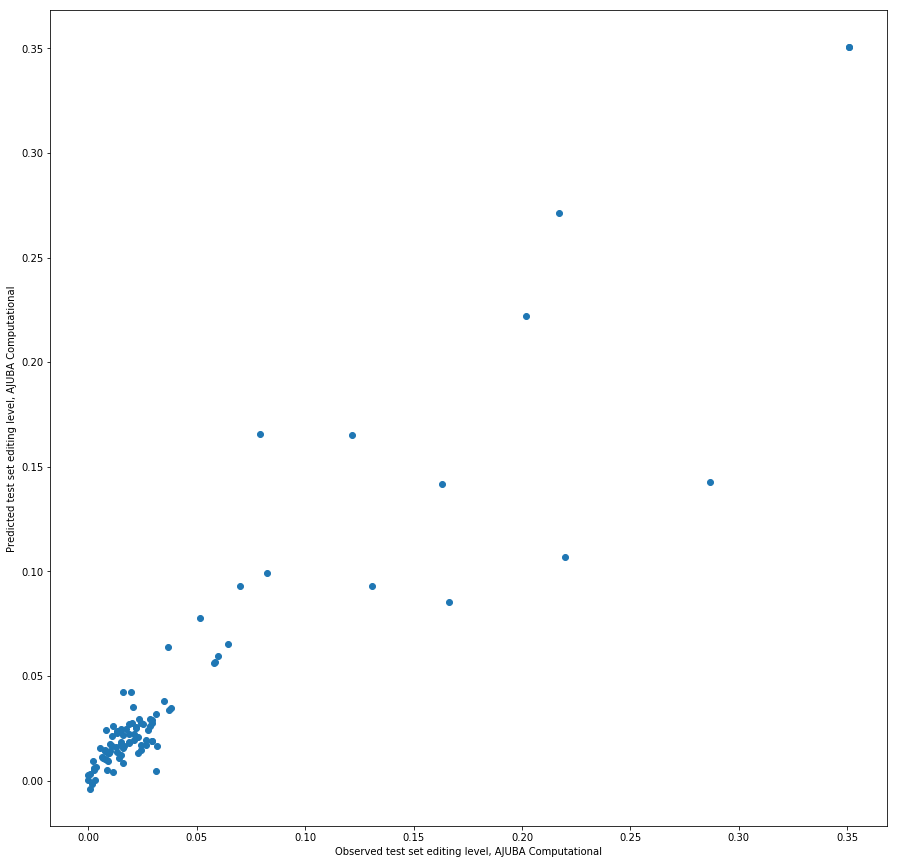

In [19]:
#plot the test set predictions 

matplotlib.rcParams['figure.figsize'] = [15, 15]
test_y=list(test_y)
test_pred=list(test_pred)
#fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(test_y,test_pred,'o')
plt.xlabel("Observed test set editing level, AJUBA Computational")
plt.ylabel("Predicted test set editing level, AJUBA Computational")
plt.show()

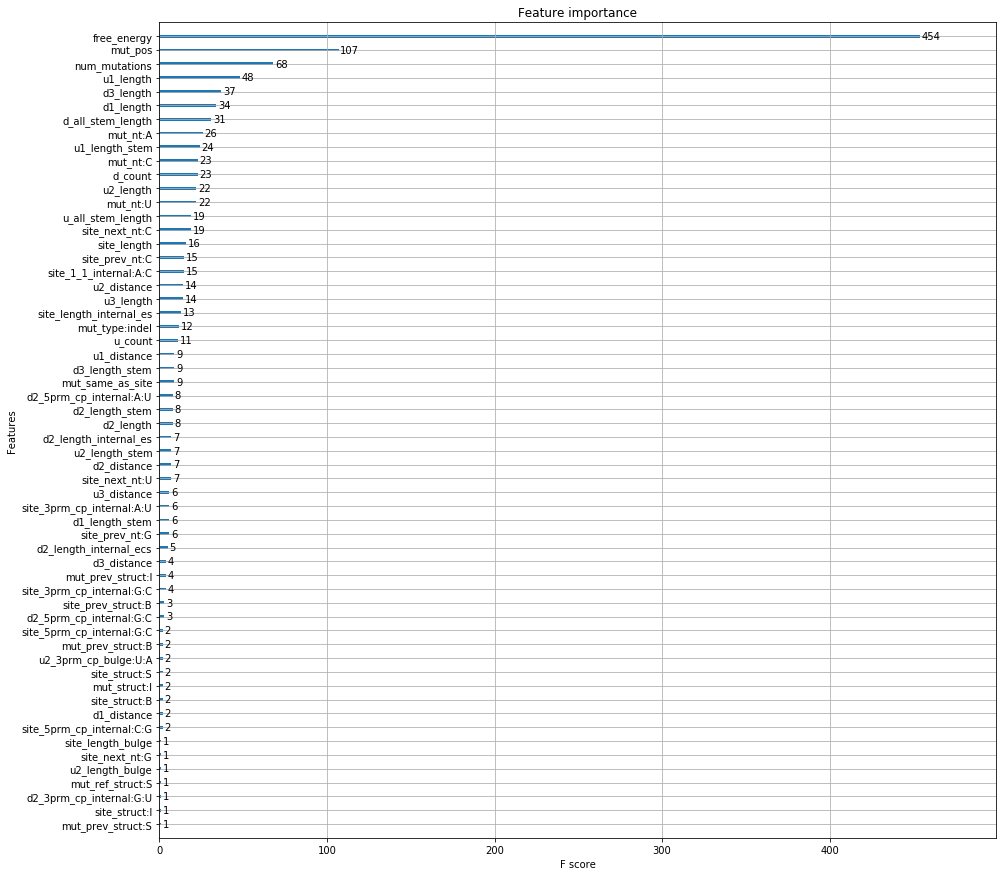

In [20]:
xgboost.plot_importance(bst)

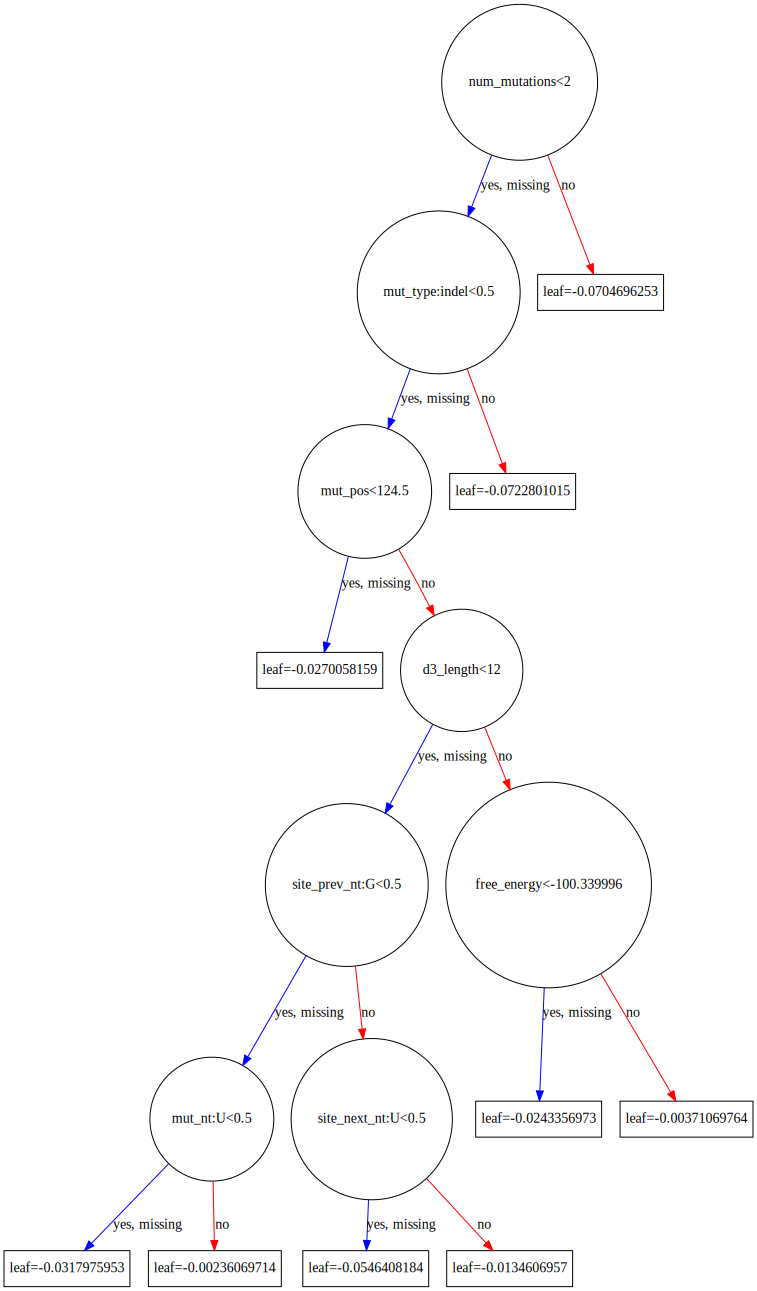

In [21]:
xgboost.to_graphviz(bst, num_trees=2)


In [22]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(test_X)


In [23]:
shap_values.shape

(99, 92)

In [24]:
# visualize prediction for isoform with the highest editing level 
max_index=test_y.index(max(test_y))
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[max_index,:], test_X.iloc[max_index,:])

In [25]:
# visualize prediction for isoform with the lowest editing level 
min_index=test_y.index(min(test_y))
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[min_index,:], test_X.iloc[min_index,:])

In [26]:
# visualize the training set predictions
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values,train_X)

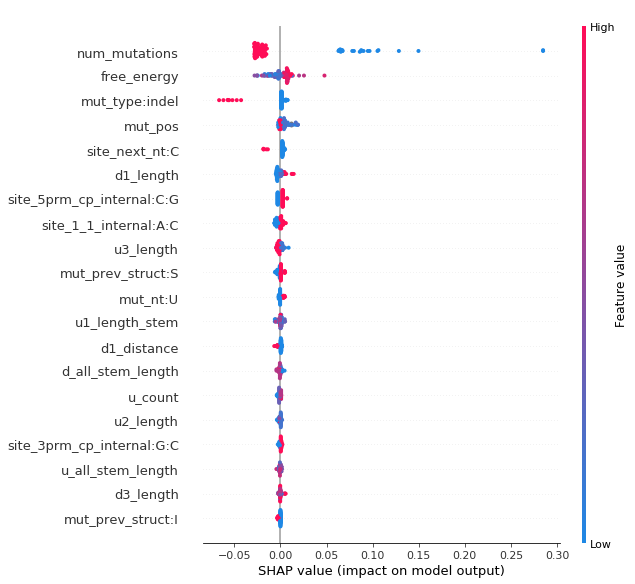

In [27]:
# summarize the effect of all the features 
shap.summary_plot(shap_values, test_X)


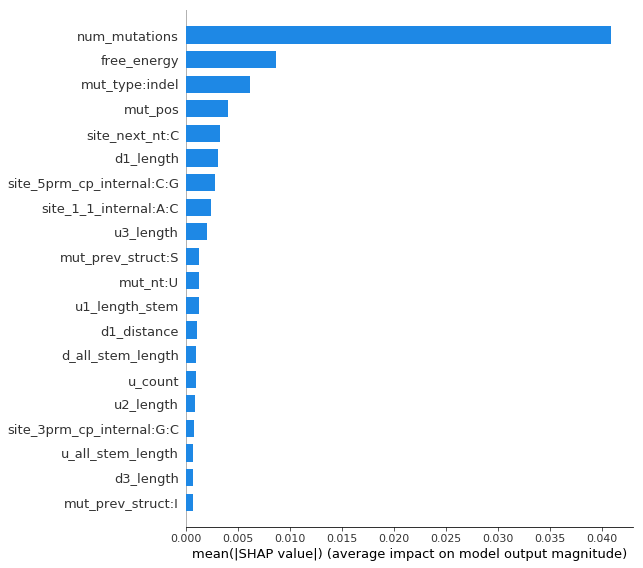

In [28]:
# We can also just take the mean absolute value of the SHAP values for each feature 
# to get a standard bar plot (produces stacked bars for multi-class outputs):
shap.summary_plot(shap_values, test_X, plot_type="bar")

In [29]:
## Compute pairwise interaction values from TreeShap
shap_interaction_values=explainer.shap_interaction_values(test_X)

In [30]:
shap_interaction_values.shape

(99, 92, 92)

In [31]:
##Average interaction values across the datapoints in the test set 
mean_interaction_values=np.mean(shap_interaction_values,axis=0)

In [32]:
Index=test_X.columns
Cols=test_X.columns
mean_interaction_values_df = pd.DataFrame(mean_interaction_values, index=Index, columns=Cols)

In [33]:
enable_plotly_in_cell()

trace = Heatmap(z=mean_interaction_values_df.values,
                   x=Cols,
                   y=Index)
tr=[trace]
iplot(tr,show_link=False)

## Computational Dataset: Feature Subsets<a name='2'>
<a href=#outline>Home</a>

In [34]:
shap_values=pd.DataFrame(shap_values,columns=Cols)

In [35]:
import feature_subsets 

In [36]:
print(feature_subsets.mut)
shap_contribs_subgroup(shap_values,feature_subsets.mut)

['num_mutations*', 'mut_exist*', 'mut_type*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*']


0.60448533

In [37]:
print(feature_subsets.site)
shap_contribs_subgroup(shap_values,feature_subsets.site)

['site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_interior_es*', 'site_length_interior_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_interior*', 'site_3prm_cp_interior*']


0.0011848614

In [38]:
print(feature_subsets.u)
shap_contribs_subgroup(shap_values,feature_subsets.u)

['u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_interior_es*', 'u1_length_interior_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_interior*', 'u1_3prm_cp_interior*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_interior_es*', 'u2_length_interior_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_interior*', 'u2_3prm_cp_interior*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length_stem*', 'u3_length_hairpin*', 'u3_length_bulge*', 'u3_length_interior_es*', 'u3_length_interior_ecs*', 'u3_5prm_cp_hairpin*', 'u3_5prm_cp_bulge*', 'u3_3prm_cp_bulge*', 'u3_5prm_cp_interior*', 'u3_3prm_cp_interior*']


0.041657727

In [39]:
print(feature_subsets.d)
shap_contribs_subgroup(shap_values,feature_subsets.d)

['d_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge*', 'd1_length_interior_es*', 'd1_length_interior_ecs*', 'd1_5prm_cp_hairpin*', 'd1_5prm_cp_bulge*', 'd1_3prm_cp_bulge*', 'd1_5prm_cp_interior*', 'd1_3prm_cp_interior*', 'd2_exist*', 'd2_distance*', 'd2_struct*', 'd2_length_stem*', 'd2_length_hairpin*', 'd2_length_bulge*', 'd2_length_interior_es*', 'd2_length_interior_ecs*', 'd2_5prm_cp_hairpin*', 'd2_5prm_cp_bulge*', 'd2_3prm_cp_bulge*', 'd2_5prm_cp_interior*', 'd2_3prm_cp_interior*', 'd3_exist*', 'd3_distance*', 'd3_struct*', 'd3_length_stem*', 'd3_length_hairpin*', 'd3_length_bulge*', 'd3_length_interior_es*', 'd3_length_interior_ecs*', 'd3_5prm_cp_hairpin*', 'd3_5prm_cp_bulge*', 'd3_3prm_cp_bulge*', 'd3_5prm_cp_interior*', 'd3_3prm_cp_interior*']


0.04446507

In [40]:
print(feature_subsets.u_d)
shap_contribs_subgroup(shap_values,feature_subsets.u_d)

['u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_interior_es*', 'u1_length_interior_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_interior*', 'u1_3prm_cp_interior*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_interior_es*', 'u2_length_interior_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_interior*', 'u2_3prm_cp_interior*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length_stem*', 'u3_length_hairpin*', 'u3_length_bulge*', 'u3_length_interior_es*', 'u3_length_interior_ecs*', 'u3_5prm_cp_hairpin*', 'u3_5prm_cp_bulge*', 'u3_3prm_cp_bulge*', 'u3_5prm_cp_interior*', 'u3_3prm_cp_interior*', 'd_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge

0.0861228

In [41]:
print(feature_subsets.mut_site)
shap_contribs_subgroup(shap_values,feature_subsets.mut_site)

['num_mutations*', 'mut_exist*', 'mut_type*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_interior_es*', 'site_length_interior_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_interior*', 'site_3prm_cp_interior*']


0.6056702

In [42]:
print(feature_subsets.no_up)
shap_contribs_subgroup(shap_values,feature_subsets.no_up)

['num_mutations*', 'mut_exist*', 'mut_type*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_interior_es*', 'site_length_interior_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_interior*', 'site_3prm_cp_interior*', 'd_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge*', 'd1_length_interior_es*', 'd1_length_interior_ecs*', 'd1_5prm_cp_hairpin*', 'd1_5prm_cp_bulge*', 'd1_3prm_cp_bulge*', 'd1_5prm_cp_interior*', 'd1_3prm_cp_interior*', 'd2_exist*', 'd2_distance*', 'd2_struct*', 'd2_length_stem*', 'd2_length_hairpin*', 'd2_length_bulge*', 'd2_length_interior_es*', 'd2_length_interior_ecs*', 'd2_5prm_cp_hairpin*', 'd2_5prm_cp_bulge*', 'd2_3prm_cp_

0.6501353

In [43]:
print(feature_subsets.no_down)
shap_contribs_subgroup(shap_values,feature_subsets.no_down)

['num_mutations*', 'mut_exist*', 'mut_type*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_interior_es*', 'site_length_interior_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_interior*', 'site_3prm_cp_interior*', 'u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_interior_es*', 'u1_length_interior_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_interior*', 'u1_3prm_cp_interior*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_interior_es*', 'u2_length_interior_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_

0.64732796

In [44]:
print(feature_subsets.site_struct)
shap_contribs_subgroup(shap_values,feature_subsets.site_struct)

['site_struct', 'site_length', 'site_length_interior_es', 'site_length_interior_ecs', 'site_3prm_cp_interior']


0.010784447

In [45]:
print(feature_subsets.site_seq)
shap_contribs_subgroup(shap_values,feature_subsets.site_seq)

['site_prev_nt*', 'site_next_nt*']


0.044894144

In [46]:
print(feature_subsets.mut_seq)
shap_contribs_subgroup(shap_values,feature_subsets.mut_seq)

['num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*']


0.51471883

In [47]:
print(feature_subsets.mut_seq_site)
shap_contribs_subgroup(shap_values,feature_subsets.mut_seq_site)

['site_prev_nt', 'site_next_nt', 'num_mutations', 'mut_pos', 'mut_site_dist', 'mut_ref_nt, mut_nt']


0.5359707

In [48]:
print(feature_subsets.no_mut)
shap_contribs_subgroup(shap_values,feature_subsets.no_mut)

['free_energy*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_interior_es*', 'site_length_interior_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_interior*', 'site_3prm_cp_interior*', 'u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_interior_es*', 'u1_length_interior_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_interior*', 'u1_3prm_cp_interior*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_interior_es*', 'u2_length_interior_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_interior*', 'u2_3prm_cp_interior*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length_stem*', 'u3_length_hairpin*',

0.18140909